In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/My Drive/Datamining/TextMining/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [3]:
!cp "/content/drive/My Drive/Datamining/TextMining/Notebooks/functions.py" .
import functions as f
import importlib
importlib.reload(f)
f.v()

2020-05-30 20:58


In [55]:
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, sent_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from keras.initializers import Constant
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
import nltk
import io
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
def plot_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [6]:
df = f.loadSampleDataSetFromSpread(gc, 'https://docs.google.com/spreadsheets/d/1mE-QcKMxy70Xt5OoVb8s0GqjS7jQiBD12WzxtmcNQck/edit#gid=1204809874');
df

,text,is_spam,is_news,sentiment
0,@FinanceExaminer @michaeltg @TheBubbleBubble I...,False,0.0,1.0
1,China Authorities Probe Alleged Illegal Bitcoi...,False,1.0,-1.0
2,ALERT: Bitcoin Cash (BCH) at Euro 380.81 incre...,False,1.0,1.0
3,Pretty cool concept. 👍 $CHR #crypto #cryptocu...,True,NaN,NaN
4,"Crypto Market Hits $200 Billion, Bitcoin Ralli...",True,NaN,NaN
...,...,...,...,...
995,@CNBC @CNBCMakeIt He says if you make 70K a ye...,False,0.0,1.0
996,https://t.co/U6p7FgOdd8 via @BitcoinEcho,False,0.0,0.0
997,The last time BTC closed above 12k for the wee...,False,0.0,1.0
998,https://t.co/o5jXwqEdbn is for #sale!#domain #...,True,NaN,NaN


In [7]:
df_val = f.loadSampleDataSetFromSpread(gc, 'https://docs.google.com/spreadsheets/d/1G0sY49Ct5AU3OAV-kVU1SSJP9_-ci8N0aCvX00e2Gkg/edit#gid=2038236874')
df_val

,text,is_spam,is_news,sentiment
0,#BTC #Bitcoin to 7500$ and after this back to ...,False,0.0,1.0
1,@APompliano @McDonalds What is the cost of tra...,False,0.0,0.0
2,"Selling at 6,500USD. Bye Bitcoin Co. Ltd. htt...",False,0.0,-1.0
3,Lets play a game as we wait for Bakkt 10K BTC ...,False,0.0,1.0
4,@GoonAlerts_ Favorite coin @sentivate $SNTVT I...,False,0.0,1.0
...,...,...,...,...
495,#Blockchain #Crypto #Bitcoin #Ethereum #Tradin...,True,NaN,NaN
496,@CalvinAyre according to your mother bitcoin i...,False,0.0,1.0
497,Sold this put last week when bitcoin was above...,False,0.0,1.0
498,Block 598628 Hash: 0x...0df6063fdfd137f13322f9...,True,NaN,NaN


In [8]:
# Esto fue para ver el texto antes de aplicar el normalize for tokenization
df.sample(n = 25, random_state=1234).text.values

array(['The much-anticipated event #BTC, is happening on 10-11 July, 👏🏽\U0001f973\U0001f973  in Barcelona 🇪🇸with the VP of Catalonia to kick off Barcelona #Trading Conference with keynote speech  #btconf2019 https://t.co/bjedXdQAtn https://t.co/MNSCNQpqXS https://t.co/E3HlOn4VlN',
       'Low-balled this purchase with a 1 sat on-chain transaction. My bitcoin bling is complete unless people start producing shoes and shit...I also promote myself to “Blockstream Spy” status😎 https://t.co/DYoCHl3sup',
       'Haven’t had an edge in a $btc trade in a while.  Trying not to die in the chop',
       'We are sorry to announce that the bitcoin blockchain passed away today.   This has nothing to do with the fact that a link to the wikileaks documents on the Clintons was uploaded to it.',
       'https://t.co/zE0DCkP3az #xrp #ripple #trx #btc #Pilot Flies Plane Unconscious For 40 Minutes During Training In Australia - #IPLfantasy #IPLFantasyLeague #IPL2019onIndiaBet - https://t.co/UHituannMV #A tr

In [9]:
# Acá vemos como queda el texto después de aplicar el normalize for tokenization
df.sample(n = 25, random_state=1234).text.apply(f.normalizeForTokenization).values

array(['the much-anticipated event <HASHTAG> , is happening on <NUMBER> - <NUMBER> july, 👏🏽\U0001f973\U0001f973 in barcelona 🇪🇸with the vp of catalonia to kick off barcelona <HASHTAG> conference with keynote speech <HASHTAG> <URL> <URL> <URL>',
       'low-balled this purchase with a <NUMBER> sat on-chain transaction. my bitcoin bling is complete unless people start producing shoes and shit\x01i also promote myself to “blockstream spy” status😎 <URL>',
       'haven’t had an edge in a $btc trade in a while. trying not to die in the chop',
       'we are sorry to announce that the bitcoin blockchain passed away today. this has nothing to do with the fact that a link to the wikileaks documents on the clintons was uploaded to it.',
       '<URL> <HASHTAG> <HASHTAG> <HASHTAG> <HASHTAG> <HASHTAG> flies plane unconscious for <NUMBER> minutes during training in australia - <HASHTAG> <HASHTAG> <HASHTAG> - <URL> <HASHTAG> trainee pilot flew unconscious for about <NUMBER> minutes through \x01',
 

# Preparacion de datos para las RNN

In [0]:
x_dev_text = df['text'].apply(f.normalizeForTokenization)
y_dev = df['is_spam']
x_test_text = df_val['text'].apply(f.normalizeForTokenization)
y_test = df_val['is_spam']

In [0]:
vocab_size = 10000+1
embedding_dim = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
validation_size = 0.2

# Seteamos max_length teniendo en cuenta el largo promedio de los tweets
max_length = 50

In [0]:
x_train_text, x_validation_text, y_train, y_validation = train_test_split(x_dev_text, y_dev, test_size = validation_size, random_state=1234)

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train_text)
x_train = tokenizer.texts_to_sequences(x_train_text)
x_validation = tokenizer.texts_to_sequences(x_validation_text)
x_test = tokenizer.texts_to_sequences(x_test_text)

In [0]:
# Guardamos el tokenizador para poder usarlo después cuando agreguemos las columnas al dataset original (otra notebook)
with io.open(path + 'Modelos/' + 'tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer.to_json())

In [0]:
x_train = pad_sequences(x_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_validation = pad_sequences(x_validation, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_test = pad_sequences(x_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Naive Bayes

In [0]:
count_vect = CountVectorizer(tokenizer=word_tokenize, max_features=5000)
x_train_NB = count_vect.fit_transform(x_dev_text) # cuenta frecuencia de tokens y define el diccionario
x_validation_NB = count_vect.transform(x_test_text) # cuenta frecuencia de tokens existentes en el diccionario

clf = MultinomialNB(alpha=1) # alpha es el smoothing parameter
NB_model = clf.fit(x_train_NB, y_dev)
pred = NB_model.predict(x_validation_NB)

In [58]:
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.758,
 'f1': 0.6702997275204359,
 'precision': 0.640625,
 'recall': 0.7028571428571428}

In [59]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[256,  69],
       [ 52, 123]], dtype=int32)>

Por las dudas pruebo NB validando contra "validación" (en lugar de test)

In [0]:
count_vect = CountVectorizer(tokenizer=word_tokenize, max_features=5000)
x_train_NB = count_vect.fit_transform(x_train_text) # cuenta frecuencia de tokens y define el diccionario
x_validation_NB = count_vect.transform(x_validation_text) # cuenta frecuencia de tokens existentes en el diccionario

clf = MultinomialNB(alpha=1) # alpha es el smoothing parameter
NB_model = clf.fit(x_train_NB, y_train)
pred = NB_model.predict(x_validation_NB)

In [61]:
{
    'f1' : f1_score(y_validation, pred),
    'accuracy': accuracy_score(y_validation, pred),
    'recall': recall_score(y_validation, pred),
    'precision': precision_score(y_validation, pred)
}

{'accuracy': 0.74,
 'f1': 0.6338028169014084,
 'precision': 0.5769230769230769,
 'recall': 0.703125}

# RNN

In [21]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           3000300   
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,166,831
Trainable params: 3,166,831
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model_gru.fit(x_train, y_train, batch_size=100, epochs=15, validation_data=(x_validation, y_validation))

Epoch 1/15
8/8 [==============================] - 1s 85ms/step - loss: 0.6679 - accuracy: 0.6488 - val_loss: 0.6281 - val_accuracy: 0.6800
Epoch 2/15
8/8 [==============================] - 0s 33ms/step - loss: 0.6567 - accuracy: 0.6488 - val_loss: 0.6343 - val_accuracy: 0.6800
Epoch 3/15
8/8 [==============================] - 0s 32ms/step - loss: 0.6490 - accuracy: 0.6488 - val_loss: 0.6273 - val_accuracy: 0.6800
Epoch 4/15
8/8 [==============================] - 0s 33ms/step - loss: 0.6476 - accuracy: 0.6488 - val_loss: 0.6284 - val_accuracy: 0.6800
Epoch 5/15
8/8 [==============================] - 0s 33ms/step - loss: 0.6437 - accuracy: 0.6488 - val_loss: 0.6247 - val_accuracy: 0.6800
Epoch 6/15
8/8 [==============================] - 0s 33ms/step - loss: 0.6391 - accuracy: 0.6500 - val_loss: 0.6246 - val_accuracy: 0.6800
Epoch 7/15
8/8 [==============================] - 0s 33ms/step - loss: 0.6319 - accuracy: 0.6488 - val_loss: 0.6202 - val_accuracy: 0.6800
Epoch 8/15
8/8 [===========

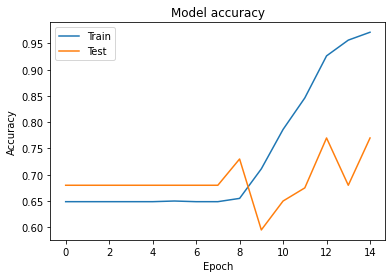

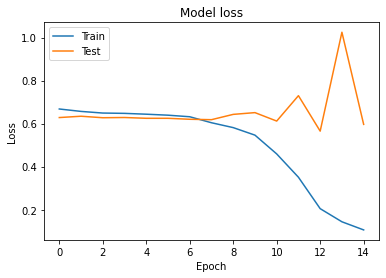

In [23]:
plot_history(history)

In [62]:
pred = model_gru.predict(x_test)
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.784,
 'f1': 0.6842105263157894,
 'precision': 0.7005988023952096,
 'recall': 0.6685714285714286}

In [25]:
tf.math.confusion_matrix(labels=y_test, predictions=(pred[:,0] > 0.5))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[275,  50],
       [ 58, 117]], dtype=int32)>

# RNN Bidireccional

In [26]:
model_bigru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences = True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_bigru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_bigru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           330240    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [27]:
history = model_bigru.fit(x_train, y_train, batch_size=100, epochs=15, validation_data=(x_validation, y_validation))

Epoch 1/15
8/8 [==============================] - 1s 168ms/step - loss: 0.6602 - accuracy: 0.6413 - val_loss: 0.6145 - val_accuracy: 0.6800
Epoch 2/15
8/8 [==============================] - 0s 45ms/step - loss: 0.6119 - accuracy: 0.6488 - val_loss: 0.5616 - val_accuracy: 0.6950
Epoch 3/15
8/8 [==============================] - 0s 44ms/step - loss: 0.5060 - accuracy: 0.7650 - val_loss: 0.5696 - val_accuracy: 0.7500
Epoch 4/15
8/8 [==============================] - 0s 47ms/step - loss: 0.4154 - accuracy: 0.8838 - val_loss: 0.5732 - val_accuracy: 0.8000
Epoch 5/15
8/8 [==============================] - 0s 42ms/step - loss: 0.2635 - accuracy: 0.9162 - val_loss: 0.5640 - val_accuracy: 0.7400
Epoch 6/15
8/8 [==============================] - 0s 45ms/step - loss: 0.1259 - accuracy: 0.9613 - val_loss: 0.7846 - val_accuracy: 0.7250
Epoch 7/15
8/8 [==============================] - 0s 43ms/step - loss: 0.0826 - accuracy: 0.9700 - val_loss: 0.7940 - val_accuracy: 0.7850
Epoch 8/15
8/8 [==========

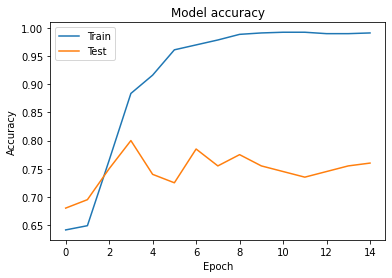

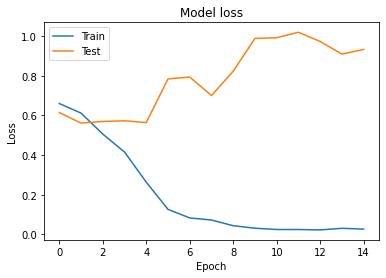

In [28]:
plot_history(history)

In [63]:
pred = model_bigru.predict(x_test)
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.724,
 'f1': 0.6079545454545453,
 'precision': 0.6045197740112994,
 'recall': 0.6114285714285714}

In [30]:
tf.math.confusion_matrix(labels=y_test, predictions=(pred[:,0] > 0.5))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[255,  70],
       [ 68, 107]], dtype=int32)>

# Embedding preentrenado

In [31]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

#load model
w2v_model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in w2v_model:
        embedding_matrix[i] = w2v_model[word]

--2020-05-31 00:15:12--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.178.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.178.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  47.0MB/s    in 34s     

2020-05-31 00:15:46 (46.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# RNN con embedding preentrenado

In [32]:
model_gru_pre = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru_pre.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru_pre.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               165120    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 3,166,831
Trainable params: 3,166,831
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model_gru_pre.fit(x_train, y_train, batch_size=100, epochs=15, validation_data=(x_validation, y_validation))

Epoch 1/15
8/8 [==============================] - 1s 80ms/step - loss: 0.6804 - accuracy: 0.6488 - val_loss: 0.6521 - val_accuracy: 0.6800
Epoch 2/15
8/8 [==============================] - 0s 34ms/step - loss: 0.6461 - accuracy: 0.6488 - val_loss: 0.6236 - val_accuracy: 0.6800
Epoch 3/15
8/8 [==============================] - 1s 100ms/step - loss: 0.6409 - accuracy: 0.6488 - val_loss: 0.6298 - val_accuracy: 0.6800
Epoch 4/15
8/8 [==============================] - 0s 33ms/step - loss: 0.6316 - accuracy: 0.6488 - val_loss: 0.6171 - val_accuracy: 0.6800
Epoch 5/15
8/8 [==============================] - 0s 38ms/step - loss: 0.6021 - accuracy: 0.6488 - val_loss: 0.5574 - val_accuracy: 0.6800
Epoch 6/15
8/8 [==============================] - 0s 34ms/step - loss: 0.5381 - accuracy: 0.6488 - val_loss: 0.5317 - val_accuracy: 0.6800
Epoch 7/15
8/8 [==============================] - 0s 34ms/step - loss: 0.5131 - accuracy: 0.6875 - val_loss: 0.5981 - val_accuracy: 0.5850
Epoch 8/15
8/8 [==========

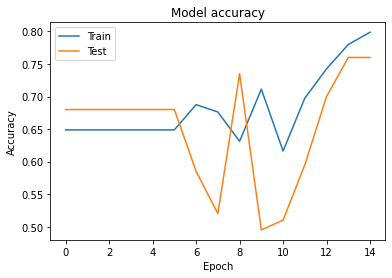

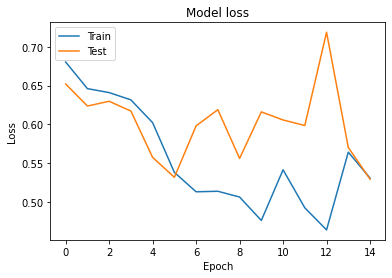

In [34]:
plot_history(history)

In [64]:
pred = model_gru_pre.predict(x_test)
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.762,
 'f1': 0.6628895184135979,
 'precision': 0.6573033707865169,
 'recall': 0.6685714285714286}

In [36]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[264,  61],
       [ 58, 117]], dtype=int32)>

In [0]:
# Dejo comentado el código para guardar y cargar
#modelFileName = 'gru_pre_2020-05-30_1355'
#modelFullPath = path + 'Modelos/' + modelFileName
#model_gru_pre.save(modelFullPath)
#new_model = tf.keras.models.load_model(modelFullPath)
#new_model.summary()

# RNN Bidireccional con embedding preentrenado

In [38]:
model_bigru_pre = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences = True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_bigru_pre.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_bigru_pre.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           330240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [39]:
history = model_bigru_pre.fit(x_train, y_train, batch_size=100, epochs=15, validation_data=(x_validation, y_validation))

Epoch 1/15
8/8 [==============================] - 1s 166ms/step - loss: 0.6721 - accuracy: 0.6225 - val_loss: 0.6221 - val_accuracy: 0.6900
Epoch 2/15
8/8 [==============================] - 0s 46ms/step - loss: 0.6169 - accuracy: 0.6562 - val_loss: 0.5895 - val_accuracy: 0.7150
Epoch 3/15
8/8 [==============================] - 0s 47ms/step - loss: 0.5741 - accuracy: 0.7038 - val_loss: 0.5424 - val_accuracy: 0.7550
Epoch 4/15
8/8 [==============================] - 0s 44ms/step - loss: 0.4996 - accuracy: 0.7887 - val_loss: 0.5093 - val_accuracy: 0.7450
Epoch 5/15
8/8 [==============================] - 0s 44ms/step - loss: 0.3744 - accuracy: 0.8325 - val_loss: 0.5022 - val_accuracy: 0.7700
Epoch 6/15
8/8 [==============================] - 0s 46ms/step - loss: 0.2840 - accuracy: 0.8963 - val_loss: 0.4888 - val_accuracy: 0.8100
Epoch 7/15
8/8 [==============================] - 0s 44ms/step - loss: 0.1729 - accuracy: 0.9400 - val_loss: 0.6147 - val_accuracy: 0.7400
Epoch 8/15
8/8 [==========

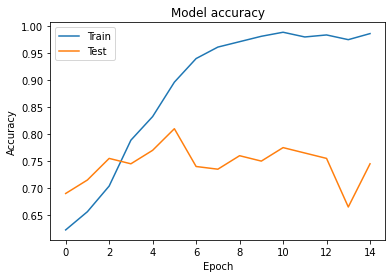

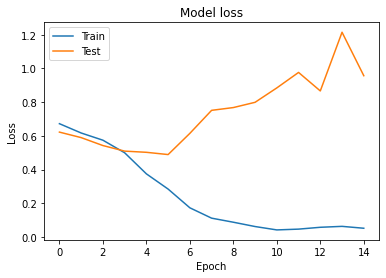

In [40]:
plot_history(history)

In [65]:
pred = model_bigru_pre.predict(x_test)
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.786,
 'f1': 0.706849315068493,
 'precision': 0.6789473684210526,
 'recall': 0.7371428571428571}

In [42]:
tf.math.confusion_matrix(labels=y_test, predictions=(pred[:,0] > 0.5))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[264,  61],
       [ 46, 129]], dtype=int32)>

# RNN (también bidireccional) con embedding preentrenado y 5-fold cross validation

In [43]:
model_gru_pre_5fold = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru_pre_5fold.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru_pre_5fold.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
gru_6 (GRU)                  (None, 128)               165120    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 3,166,831
Trainable params: 3,166,831
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_bigru_pre_5fold = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences = True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_bigru_pre_5fold.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_bigru_pre_5fold.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 256)           330240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

In [0]:
tokenizer_cv = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_cv.fit_on_texts(x_dev_text)
x_dev_cv = tokenizer_cv.texts_to_sequences(x_dev_text)
x_test_cv = tokenizer_cv.texts_to_sequences(x_test_text)

In [0]:
x_dev_cv = pad_sequences(x_dev_cv, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_test_cv = pad_sequences(x_test_cv, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [47]:
kf = KFold(5, shuffle = True, random_state=1234)
for train_cv, test_cv in kf.split(x_dev_cv):
    # Entreno las 2 redes simultaneamente :)
    model_gru_pre_5fold.fit(
        x_dev_cv[train_cv], y_dev[train_cv],
        batch_size=100, epochs=10,
        validation_data=(x_dev_cv[test_cv], y_dev[test_cv]))
    model_bigru_pre_5fold.fit(
        x_dev_cv[train_cv], y_dev[train_cv],
        batch_size=100, epochs=10,
        validation_data=(x_dev_cv[test_cv], y_dev[test_cv]))

Epoch 1/10
8/8 [==============================] - 1s 69ms/step - loss: 0.6787 - accuracy: 0.6475 - val_loss: 0.6522 - val_accuracy: 0.6800
Epoch 2/10
8/8 [==============================] - 0s 33ms/step - loss: 0.6435 - accuracy: 0.6488 - val_loss: 0.6311 - val_accuracy: 0.6800
Epoch 3/10
8/8 [==============================] - 0s 33ms/step - loss: 0.6444 - accuracy: 0.6488 - val_loss: 0.6290 - val_accuracy: 0.6800
Epoch 4/10
8/8 [==============================] - 0s 33ms/step - loss: 0.6343 - accuracy: 0.6488 - val_loss: 0.6213 - val_accuracy: 0.6800
Epoch 5/10
8/8 [==============================] - 0s 32ms/step - loss: 0.6072 - accuracy: 0.6500 - val_loss: 0.5807 - val_accuracy: 0.7100
Epoch 6/10
8/8 [==============================] - 0s 34ms/step - loss: 0.5398 - accuracy: 0.7325 - val_loss: 0.5523 - val_accuracy: 0.6950
Epoch 7/10
8/8 [==============================] - 0s 34ms/step - loss: 0.4830 - accuracy: 0.7713 - val_loss: 0.5122 - val_accuracy: 0.7400
Epoch 8/10
8/8 [===========

In [66]:
pred = model_gru_pre_5fold.predict(x_test_cv) 
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.756,
 'f1': 0.61875,
 'precision': 0.6827586206896552,
 'recall': 0.5657142857142857}

In [49]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[279,  46],
       [ 76,  99]], dtype=int32)>

In [67]:
pred = model_bigru_pre_5fold.predict(x_test_cv) 
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.752,
 'f1': 0.6457142857142857,
 'precision': 0.6457142857142857,
 'recall': 0.6457142857142857}

In [51]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[263,  62],
       [ 62, 113]], dtype=int32)>

In [53]:
# Guardo el modelo que dio mejor hasta ahora
modelFileName = 'spam_bigru_pre_2020-05-30_0000'
#modelFullPath = path + 'Modelos/' + modelFileName
#model_bigru_pre.save(modelFullPath)
#new_model = tf.keras.models.load_model(modelFullPath)
#new_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Datamining/TextMining/Modelos/spam_bigru_pre_2020-05-30_2120/assets
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           330240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
____________________________________________